In [1]:
import os
import lightning as L
from lightning.pytorch.callbacks import LearningRateMonitor, ModelCheckpoint
from torchvision import transforms as T
import pandas as pd
from Utils.Dataloader import CropDataset
import matplotlib.pyplot as plt
import torch.utils.data as data
from Utils.TextToImage import unique_char_mapping
from Utils.Filters import applyTransforms

from PIL import Image
import numpy as np
import torch

from Utils.TextToImage import TextToImage
from SketchKeras.sketch_model import SketchKeras
import Utils.sketchkeras as SK 
import Utils.Predict as P 


In [2]:
DATASET_PATH = './custom_datasets/datasets/Ascii_scraping/ascii_art_3_2.csv'
PATH_RUNS = os.environ.get("PATH_RUNS", "saved_models/")
CHECKPOINT_PATH = os.environ.get("PATH_CHECKPOINT", os.path.join(PATH_RUNS, "checkpoints/"))
NUM_WORKERS = os.cpu_count()

In [3]:

df = pd.read_csv(DATASET_PATH)
df.columns =["h","w",'Text']

df['Text'] = df['Text'].apply(lambda x : x.replace('$','\\$'))
text = ' '.join(df['Text'].values)

chardict = unique_char_mapping(text)
inv_chardict = {v: k for k, v in chardict.items()}




dataset = CropDataset(df,
                      dictionary=chardict,
                      transforms=T.Compose([applyTransforms,
                                            T.ToPILImage(),
                                            T.Grayscale(num_output_channels=1),
                                            T.Resize((64, 64)),
                                            T.ToTensor(),
                                            T.Normalize(mean=[0.5], std=[0.5])
                                            ]),
                      kernel_size=3)

In [4]:
from VIT.Clasification import ViT
model_kwargs={
        "embed_dim": 256,
        "hidden_dim": 512,
        "num_heads": 8,
        "num_layers": 6,
        "patch_size": 8,
        "num_channels": 1,
        "num_patches": 64,
        "num_classes": len(chardict),
        "dropout": 0.2,
        "lr": 1e-3,
    }
# model = ViT(**model_kwargs)
model = ViT.load_from_checkpoint("saved_models/checkpoints/VIT/SwaV-epoch=14-train_loss=0.00.ckpt",**model_kwargs)


In [5]:
trainer = L.Trainer(
    default_root_dir=os.path.join(PATH_RUNS, "VIT/"),
    accelerator="auto",
    devices=1,
    max_epochs=15,
    callbacks=[
        ModelCheckpoint(dirpath=CHECKPOINT_PATH + "VIT/",save_weights_only=True, mode="min", monitor="train_loss", filename="SwaV-{epoch:02d}-{train_loss:.2f}"),
        LearningRateMonitor("epoch"),
    ],
)

train_loader = data.DataLoader(dataset, batch_size=32, num_workers=NUM_WORKERS, shuffle=True)

# trainer.fit(model, train_loader)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [6]:
SKETCH_PATH = 'SketchKeras/model.pth'
sketchKeras = SketchKeras()
sketchKeras.load_state_dict(torch.load(SKETCH_PATH))
sketchKeras.to(model.device)

SketchKeras(
  (downblock_1): Sequential(
    (0): ReflectionPad2d((1, 1, 1, 1))
    (1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
    (2): BatchNorm2d(32, eps=0.001, momentum=0, affine=True, track_running_stats=True)
    (3): ReLU()
  )
  (downblock_2): Sequential(
    (0): ReflectionPad2d((1, 1, 1, 1))
    (1): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2))
    (2): BatchNorm2d(64, eps=0.001, momentum=0, affine=True, track_running_stats=True)
    (3): ReLU()
    (4): ReflectionPad2d((1, 1, 1, 1))
    (5): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
    (6): BatchNorm2d(64, eps=0.001, momentum=0, affine=True, track_running_stats=True)
    (7): ReLU()
  )
  (downblock_3): Sequential(
    (0): ReflectionPad2d((1, 1, 1, 1))
    (1): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2))
    (2): BatchNorm2d(128, eps=0.001, momentum=0, affine=True, track_running_stats=True)
    (3): ReLU()
    (4): ReflectionPad2d((1, 1, 1, 1))
    (5): Conv2d(128, 128, kernel_size=(3, 3), st

In [7]:
def process(image,patch_size=16,stride=4,theshold=253):
    img_shape = image.shape

    image = SK.load_image(image)

    image = sketchKeras(image.to(model.device))
    image = image.cpu().detach().numpy()
    
    sketch_image = SK.postprocess(image[0])
    sketch_image = T.ToPILImage()(sketch_image)
    sketch_image = T.Resize(size=(img_shape[0],img_shape[1]))(sketch_image)
    sketch_image= np.array(sketch_image)
    # print(sketch_image)
    sketch_image = np.where(sketch_image > theshold, 255, 0).astype(np.uint8)
    # plt.imshow(sketch_image,cmap='gray')

    # plt.show()
    dataloader , images_char_width, images_char_height ,original_size= P.preprocess_image(sketch_image,patch_size,stride)
    predictions = P.predict(model, dataloader)
    
    text = P.postprocess(predictions, images_char_width, images_char_height, inv_chardict)
    
    text_image = TextToImage(text)
    text_image = T.ToPILImage()(text_image)
    text_image = T.Resize(original_size)(text_image)

    return image, sketch_image, text_image, text

/home/pablo/miniconda3/envs/ascii/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/home/pablo/miniconda3/envs/ascii/lib/python3.10/site-packages/matplotlib/_tight_bbox.py:67: RuntimeWarning: divide by zero encountered in scalar divide
  fig.patch.set_bounds(x0 / w1, y0 / h1,
/home/pablo/miniconda3/envs/ascii/lib/python3.10/site-packages/matpl

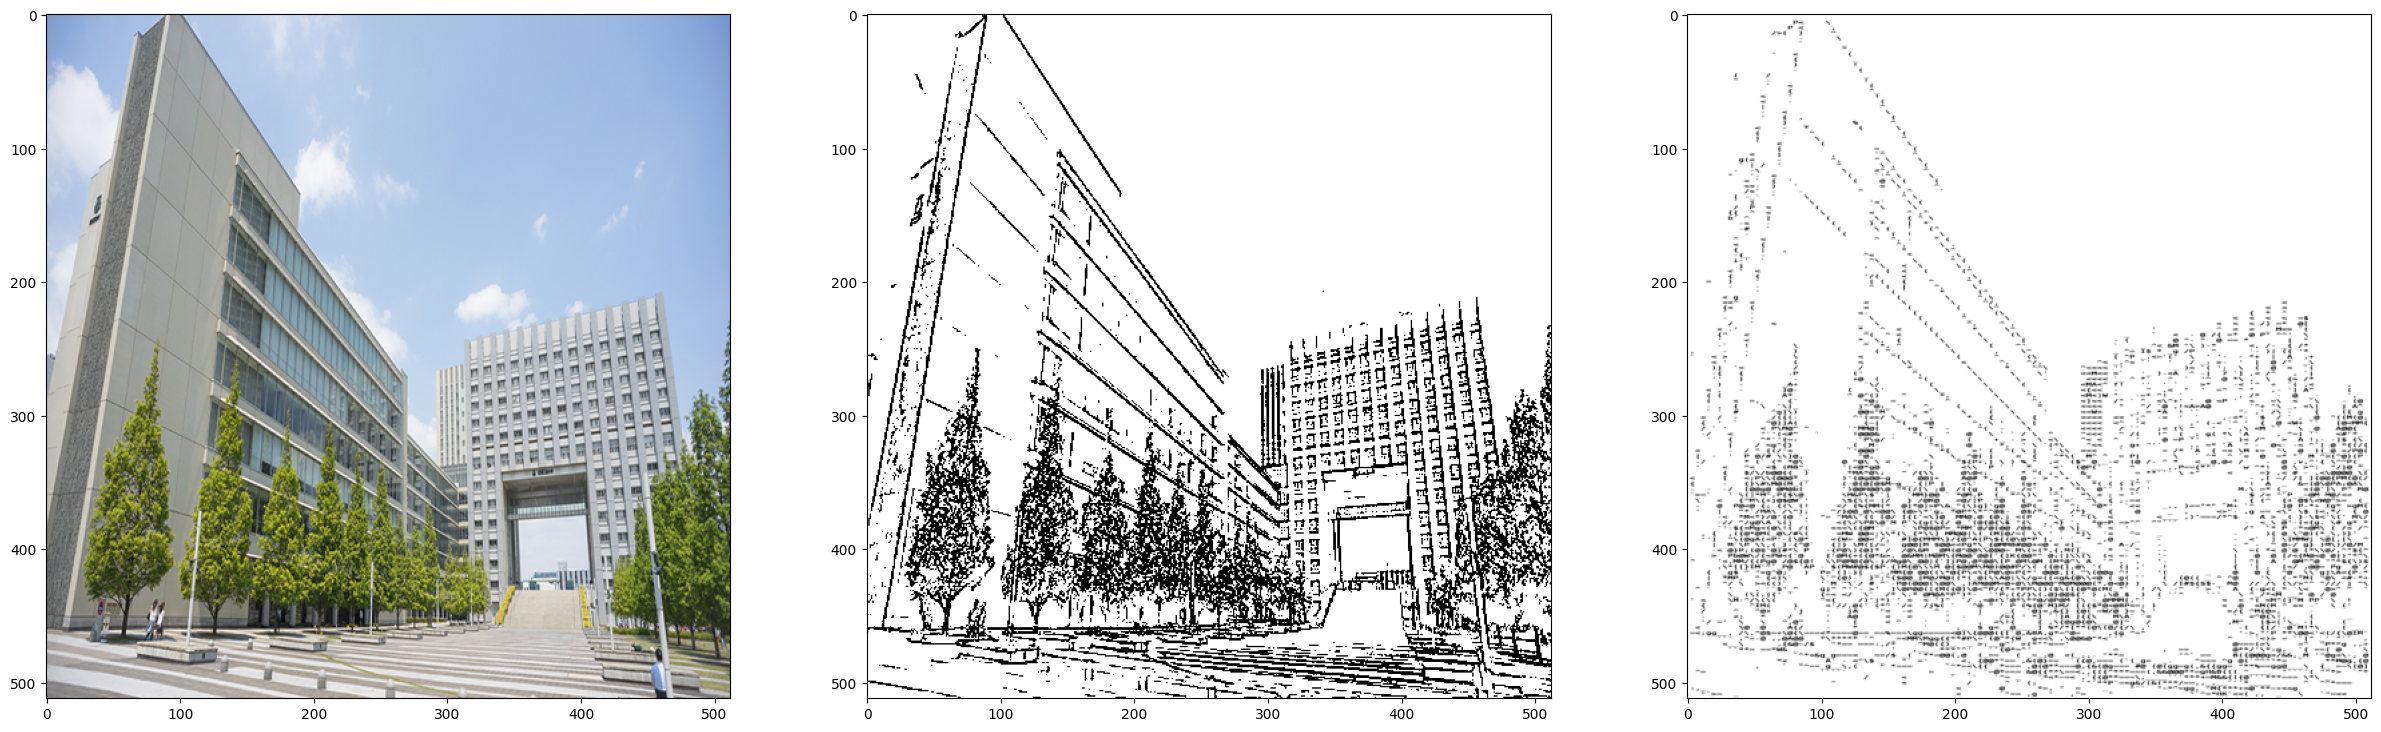


                   P<    \                                                                                                   
                  P <     ,                                                                                                  
               />(  )     ^                                                                                                  
                    -      \                                                                                                 
                    `       _                                                                                                
                            ^                                                                                                
               '   <         (                                                                                               
                   {          _                                                                                      

In [8]:
with torch.no_grad():
    model.eval()
    img_path = 'sit_toyosu.png'
    original = np.array(Image.open(img_path).convert('RGB').resize((512,512)))
    image, sketch_image, text_image, text = process(original,patch_size=16,stride=4)
    
    plt.figure(figsize=(30,10))
    plt.subplot(1,3,1)
    plt.imshow(original)
    plt.subplot(1,3,2)
    plt.imshow(sketch_image,cmap='gray')
    plt.subplot(1,3,3)
    plt.imshow(text_image,cmap='gray')
    plt.show()
    print(text)

In [10]:
text_image.resize((1024,1024)).save('output.png')

In [10]:
import gradio as gr
import cv2

def process_image(input_image,input_image_size,patch_size,stride,theshold):
    with torch.no_grad():
        model.eval()

        input_image = cv2.resize(input_image, (input_image_size,input_image_size))
        _ , processed_image1_gr, processed_image2_gr, text = process(input_image,patch_size=patch_size,stride=stride,theshold=theshold)


    return [processed_image1_gr, processed_image2_gr,text ]

# Create Gradio interface
input_image = gr.components.Image()
input_image_size = gr.components.Slider(minimum=64, maximum=512, value=256, label="Image Size")
theshold = gr.components.Slider(minimum=0, maximum=255, value=250, label="Theshold")
patch_size = gr.components.Slider(minimum=4, maximum=64, value=16, label="Patch Size")
stride = gr.components.Slider(minimum=1, maximum=16, value=4, label="Stride")
output_image1 = gr.components.Image(type= "numpy",label="Processed Image 1")
output_image2 = gr.components.Image(type= "numpy",label="Processed Image 2")
output_text = gr.components.Textbox(label="Processing Details")

gr.Interface(fn=process_image, 
             inputs=[input_image, input_image_size,patch_size,stride,theshold],
             outputs=[output_image1,output_image2, output_text], 
             title="Ascii Art Generator",
             description="Generate Ascii Art from an image").launch()


Running on local URL:  http://127.0.0.1:7860

To create a public link, set `share=True` in `launch()`.


IMPORTANT: You are using gradio version 4.18.0, however version 4.29.0 is available, please upgrade.
--------


/home/pablo/miniconda3/envs/ascii/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/home/pablo/miniconda3/envs/ascii/lib/python3.10/site-packages/matplotlib/_tight_bbox.py:67: RuntimeWarning: divide by zero encountered in scalar divide
  fig.patch.set_bounds(x0 / w1, y0 / h1,
/home/pablo/miniconda3/envs/ascii/lib/python3.10/site-packages/matpl